In [13]:
import random
from abc import ABCMeta, abstractmethod

import numpy as np
import matplotlib.pyplot as plt


In [14]:
class Task:
    def __init__(self, uid, create_time, exe_time, priority=None, deadline=None):
        self.id = uid
        self.create_time = create_time
        self.exe_time = exe_time
        self.exe_remain = exe_time
        self.deadline = deadline
        self.priority = priority
        self.exe_start = None
        self.exe_finish = None
        self.completed = False
        self.wait_time = 0
        
    def exe_tick(self, sys_time):
        if self.exe_time == self.exe_remain:
            self.exe_start = sys_time
            
        self.exe_remain -= 1
        
        if self.exe_remain == 0:
            self.completed = True
            self.exe_finish = sys_time
            self.wait_time = sys_time - self.exe_time - self.create_time
            
    def __eq__(self, other):
        return self.id == other.id
             
    def __str__(self):
        return f"Task {self.id} Creation time = {self.create_time} " + \
               f"exe_time = {self.exe_time} Deadline = {self.deadline}"
        
    def __repr__(self):
        return f"Task {self.id}"
         

In [15]:
class Generator(metaclass=ABCMeta):
    def __init__(self, min_exe_time, max_exe_time):
        self.initial_id = 0
        self.max_time = max_exe_time
        self.min_time = min_exe_time
     
    def generate_task(self, curr_time, deadline_coef=2):
        
        exe_time = random.randint(self.min_time, self.max_time + 1)
        deadline = curr_time + exe_time \
                    + random.randint(exe_time, deadline_coef * exe_time)
        task = Task(self.initial_id, curr_time, exe_time, deadline=deadline)
        self.initial_id += 1
        return task
    
    @abstractmethod    
    def generate_tasks(self, curr_time):
        tasks = []
        return tasks
        
        
class UniformGenerator(Generator):
    def __init__(self, min_exe_time, max_exe_time, tasks_range=(0, 3)):
        """
        :param tuple[int] tasks_range: min and max number of generated tasks per timestep
        """
        Generator.__init__(self, min_exe_time, max_exe_time)
        self.range = tasks_range
        
    def generate_tasks(self, curr_time):
        tasks = []
        n_create = random.randint(self.range[0], self.range[1])
        for i in range(n_create):
            tasks.append(self.generate_task(curr_time))
        return tasks
    

class ErlangGenerator(Generator):
    def __init__(self, min_exe_time, max_exe_time, shape_param=1.5, scale_param=1):
        """
        :param tuple[int] tasks_range: min and max number of generated tasks per timestep
        """
        Generator.__init__(self, min_exe_time, max_exe_time)
        self.shape_param = shape_param
        self.scale_param = scale_param
        
    def generate_tasks(self, curr_time):
        tasks = []
        n_create = int(random.gammavariate(self.shape_param, self.scale_param))
        for i in range(n_create):
            tasks.append(self.generate_task(curr_time))
        return tasks

    
class SimpleGenerator(Generator):
    def __init__(self, min_exe_time, max_exe_time, intensity=0.1):
        Generator.__init__(self, min_exe_time, max_exe_time)
        self.intensity = intensity
        
    def generate_task(self, curr_time):
        chance = random.random()
        if chance < self.intensity:
            exe_time = random.randint(self.min_time, self.max_time + 1)
            deadline = curr_time + exe_time + random.randint(exe_time,
                                                             2 * exe_time)
            
            task = Task(self.initial_id, curr_time, exe_time, deadline=deadline)
            self.initial_id += 1
            return task
        return None
    

In [16]:
class Queue(metaclass=ABCMeta):
    
    def __init__(self):
        self._queue = []
        self._len = 0 
    
    @property
    def queue(self):
        return self._queue
        
    @property
    def len(self):
        return self._len
    
    @abstractmethod
    def push_task(self):
        None
    
    @abstractmethod
    def get_task(self):
        None
        
    @abstractmethod
    def check_deadlines(self, sys_time):
        None
        
    def push_tasks(self, tasks):
        for task in tasks:
            self.push_task(task)
    

class FIFO(Queue):
    
    def __init__(self):
        Queue.__init__(self)
    
    def push_task(self, task):
        if isinstance(task, Task):
            self._queue.append(task)
            self._len += 1
        
    def get_task(self):
        if self._len == 0:
            return None
        else:
            self._len -= 1
            return self._queue.pop(0)
        
    def check_deadlines(self, sys_time):
        dropped = []
        for t in self._queue:
            if t.deadline < (sys_time + t.exe_remain):
                dropped.append(t)
                self._queue.remove(t)
                self._len -= 1
        return dropped
        
        
class LIFO(Queue):
    
    def __init__(self):
        Queue.__init__(self)
    
    def push_task(self, task):
        if isinstance(task, Task):
            self._queue.append(task)
            self._len += 1
        
    def get_task(self):
        if self._len == 0:
            return None
        else:
            self._len -= 1
            return self._queue.pop(self.len)  
        
    def check_deadlines(self, sys_time):
        dropped = []
        for t in self._queue:
            if t.deadline < (sys_time + t.exe_remain):
                dropped.append(t)
                self._queue.remove(t)
                self._len -= 1
        return dropped
               
            
class EDF(Queue):
    """
    Earlyest Deadline First queue
    """
    def __init__(self):
        Queue.__init__(self)
        self.deadlines = []

    def push_task(self, task):
        if isinstance(task, Task):
            self._queue.append(task)
            self._len += 1
            self.deadlines.append(task.deadline)
            
    def get_task(self):
        if self._len == 0:
            return None
        else:
            self._len -= 1
            early_deadline = min(self.deadlines)
            index = self.deadlines.index(early_deadline)
            task = self._queue.pop(index)
            _ = self.deadlines.pop(index)
            return task
        
    def check_deadlines(self, sys_time):
        dropped = []
        for t in self._queue:
            if t.deadline < (sys_time + t.exe_remain):
                dropped.append(t)
                index = self._queue.index(t)
                self._queue.remove(t)
                _ = self.deadlines.pop(index)
                self._len -= 1
        return dropped
      
    
class PRQueue(Queue):
    """
    2-level priority queue, where new tasks have higher priority.
    """
    
    def __init__(self):
        Queue.__init__(self)
        self.queue_new = FIFO()
        self.queue_started = FIFO()

    def push_task(self, task):
        if isinstance(task, Task):
            self._queue.append(task)
            self._len += 1
            if task.exe_time == task.exe_remain:
                self.queue_new.push_task(task)
            else:
                self.queue_started.push_task(task)
            
    def get_task(self):
        task = None
        if self._len == 0:
            return task
        elif self.queue_new.len > 0:
            self._len -= 1
            task = self.queue_new.get_task()
            self._queue.remove(task)
        elif self.queue_started.len > 0:
            self._len -= 1
            task = self.queue_started.get_task()
            self._queue.remove(task)
        return task
    
    def check_deadlines(self, sys_time):
        dropped = []
        for t in self._queue:
            if t.deadline < (sys_time + t.exe_remain):
                dropped.append(t)
                self._queue.remove(t)
                self._len -= 1
                
        _ = self.queue_new.check_deadlines(sys_time)
        _ = self.queue_started.check_deadlines(sys_time)
        return dropped
        

In [17]:
class Processor:
    """
    Simple processor. It may has several cores (max_proc parameter).
    """
    def __init__(self):
        self.sys_time = 0
        self.is_free = True
        self.curr_tasks = []
        self.max_proc = 1
        
        self.downtime = 0
        
    def set_task(self, task):
        if isinstance(task, Task) and self.is_free:
            self.curr_tasks.append(task)
            self.is_free = len(self.curr_tasks) < self.max_proc
        
    def run_tick(self):
        """
        :return list[Task] currents:
        :return list[Task] completed:
        :return list[Task] back_to_queue: на случай прерываний
        """
        self.sys_time += 1
        currents = []
        completed = []
        back_to_queue = []
        
        if len(self.curr_tasks) == 0:
            self.downtime += 1
        
        for task in self.curr_tasks:
            task.exe_tick(self.sys_time)
            if task.completed:
                completed.append(task)
            else:
                currents.append(task)
                
        self.curr_tasks = currents
        self.is_free = len(self.curr_tasks) < self.max_proc
        return currents, completed, back_to_queue
    
    def drop_task(self, task):
        for curr_task in self.curr_tasks:
            if curr_task == task:
                self.curr_tasks.remove(task)
                
                
class RRProcessor(Processor):
    """
    For Round Robin sheduling.
    Run each task no longer than quant time and return it to queue.
    """
    
    def __init__(self, quant):
        Processor.__init__(self)
        self.quant = quant
        
    def run_tick(self):
        """
        :return list[Task] currents:
        :return list[Task] completed:
        :return list[Task] back_to_queue: на случай прерываний
        """
        self.sys_time += 1
        currents = []
        completed = []
        back_to_queue = []
        
        if len(self.curr_tasks) == 0:
            self.downtime += 1
        
        for i, task in enumerate(self.curr_tasks):
            task.exe_tick(self.sys_time)
            if task.completed:
                completed.append(task)
            else:
                curr_exe_time = task.exe_time - task.exe_remain
                if curr_exe_time % self.quant == 0:
                    back_to_queue.append(task)
                else:
                    currents.append(task)
                
        self.curr_tasks = currents
        self.is_free = len(self.curr_tasks) < self.max_proc
        return currents, completed, back_to_queue
    

In [18]:
class RTS_sheduler:
    
    def __init__(self, generator, queue, processor):
        self.gen = generator
        self.queue = queue
        self.proc = processor
        self.sys_time = 0
        self.completed_tasks = []
        self.dropped_tasks = []
        self.created_tasks = []
        
    def simulate_steps(self, n_steps):
        
        for i in range(n_steps):
            new_tasks = self.gen.generate_tasks(self.sys_time)
            self.created_tasks += new_tasks
            self.queue.push_tasks(new_tasks)
            # print("STEP", i, "Created", new_tasks)
            
            while self.proc.is_free and self.queue.len > 0:
                t = self.queue.get_task()
                if t.deadline < (self.sys_time + t.exe_remain):
                    # print("Dropped", t)
                    self.dropped_tasks.append(t)
                else:
                    # print("Proc", t)
                    self.proc.set_task(t)
                
            currents, completed, back_to_q = self.proc.run_tick()
            # if len(completed) > 0:
                # print("Completed", completed)
            self.dropped_tasks += self.queue.check_deadlines(self.sys_time)
            self.completed_tasks += completed
            self.sys_time += 1

In [19]:
simul_steps = 5000
min_exe_time = 1
max_exe_time = 5
quant = 3

intensities = np.arange(0.2, 4, step=0.2)

sys1_downtime = []
sys2_downtime = []
sys3_downtime = []

sys1_wait_time = []
sys2_wait_time = []
sys3_wait_time = []

sys1_n_dropped = []
sys2_n_dropped = []
sys3_n_dropped = []

sys1_n_completed = []
sys2_n_completed = []
sys3_n_completed = []


for i, intensity in enumerate(intensities):
    g1 = ErlangGenerator(min_exe_time, max_exe_time, shape_param=intensity)
    q1 = EDF()
    p1 = Processor()
    
    system1 = RTS_sheduler(g1, q1, p1)
    system1.simulate_steps(simul_steps)
    
    g2 = ErlangGenerator(min_exe_time, max_exe_time, shape_param=intensity)
    q2 = FIFO()
    p2 = RRProcessor(quant)
    
    system2 = RTS_sheduler(g2, q2, p2)
    system2.simulate_steps(simul_steps)
    
    g3 = ErlangGenerator(min_exe_time, max_exe_time, shape_param=intensity)
    q3 = FIFO()
    p3 = Processor()
    
    system3 = RTS_sheduler(g3, q3, p3)
    system3.simulate_steps(simul_steps)
    
    sys1_downtime.append(system1.proc.downtime / system1.sys_time)
    sys2_downtime.append(system2.proc.downtime / system2.sys_time)
    sys3_downtime.append(system3.proc.downtime / system3.sys_time)
    
    wait = 0
    for task in system1.completed_tasks:
        wait += task.wait_time
    sys1_wait_time.append(wait / len(system1.completed_tasks))
        
    wait = 0
    for task in system2.completed_tasks:
        wait += task.wait_time
    sys2_wait_time.append(wait / len(system2.completed_tasks))
    
    wait = 0
    for task in system3.completed_tasks:
        wait += task.wait_time
    sys3_wait_time.append(wait / len(system3.completed_tasks))
    
    sys1_n_dropped.append(len(system1.dropped_tasks) / len(system1.created_tasks))
    sys2_n_dropped.append(len(system2.dropped_tasks) / len(system2.created_tasks))
    sys3_n_dropped.append(len(system3.dropped_tasks) / len(system3.created_tasks))
    
    sys1_n_completed.append(len(system1.completed_tasks) / len(system1.created_tasks))
    sys2_n_completed.append(len(system2.completed_tasks) / len(system2.created_tasks))
    sys3_n_completed.append(len(system3.completed_tasks) / len(system3.created_tasks))


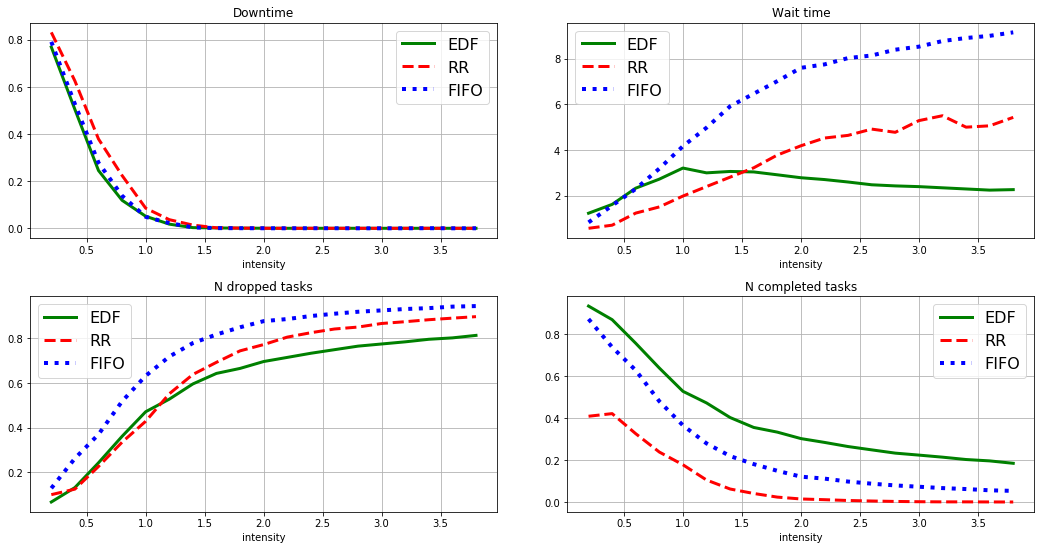

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 9))
    
ax[0, 0].plot(intensities, sys1_downtime, color="green", linewidth=3, ls="-")
ax[0, 0].plot(intensities, sys2_downtime, color="red", linewidth=3, ls="--")
ax[0, 0].plot(intensities, sys3_downtime, color="blue", linewidth=4, ls=":")
ax[0, 0].set(title="Downtime", xlabel="intensity")
ax[0, 0].legend(["EDF", "RR", "FIFO"], fontsize=16, loc=0)
ax[0, 0].grid()

ax[0, 1].plot(intensities, sys1_wait_time, color="green", linewidth=3, ls="-")
ax[0, 1].plot(intensities, sys2_wait_time, color="red", linewidth=3, ls="--")
ax[0, 1].plot(intensities, sys3_wait_time, color="blue", linewidth=4, ls=":")
ax[0, 1].set(title="Wait time", xlabel="intensity")
ax[0, 1].legend(["EDF", "RR", "FIFO"], fontsize=16, loc=0)
ax[0, 1].grid()

ax[1, 0].plot(intensities, sys1_n_dropped, color="green", linewidth=3, ls="-")
ax[1, 0].plot(intensities, sys2_n_dropped, color="red", linewidth=3, ls="--")
ax[1, 0].plot(intensities, sys3_n_dropped, color="blue", linewidth=4, ls=":")
ax[1, 0].set(title="N dropped tasks", xlabel="intensity")
ax[1, 0].legend(["EDF", "RR", "FIFO"], fontsize=16, loc=0)
ax[1, 0].grid()

ax[1, 1].plot(intensities, sys1_n_completed, color="green", linewidth=3, ls="-")
ax[1, 1].plot(intensities, sys2_n_completed, color="red", linewidth=3, ls="--")
ax[1, 1].plot(intensities, sys3_n_completed, color="blue", linewidth=4, ls=":")
ax[1, 1].set(title="N completed tasks", xlabel="intensity")
ax[1, 1].legend(["EDF", "RR", "FIFO"], fontsize=16, loc=0)
ax[1, 1].grid()


plt.subplots_adjust(wspace=0.15, hspace=0.27)
plt.show()

In [26]:
n_create = []
n_drop = []
n_finish = []

n_create2 = []
n_drop2 = []
n_finish2 = []

g = ErlangGenerator(1, 5, shape_param=1.5)
q = EDF()
p = Processor()

rts = RTS_sheduler(g, q, p)

g2 = ErlangGenerator(1, 5, shape_param=1.5)
q2 = FIFO()
p2 = RRProcessor(3)

rts2 = RTS_sheduler(g2, q2, p2)

for i in range(0, 1000, 10):
    
    rts.simulate_steps(10)
    
    n_finish.append(len(rts.completed_tasks))
    n_drop.append(len(rts.dropped_tasks))
    n_create.append(len(rts.created_tasks))
    
for i in range(0, 1000, 10):
    
    rts2.simulate_steps(10)
    
    n_finish2.append(len(rts2.completed_tasks))
    n_drop2.append(len(rts2.dropped_tasks))
    n_create2.append(len(rts2.created_tasks))


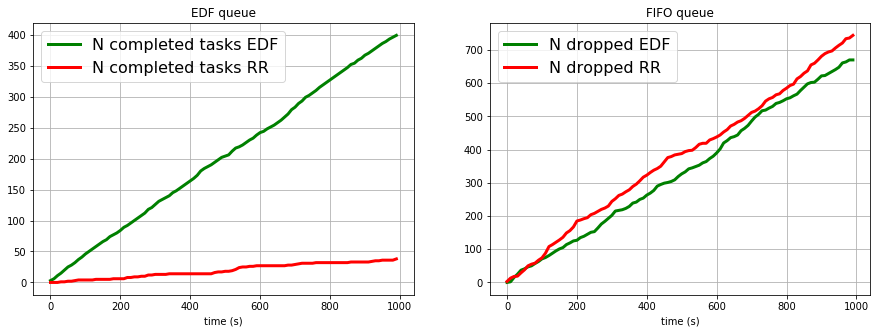

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
ax[0].plot(range(0, 1000, 10), n_finish, color="green", linewidth=3, ls="-")
ax[0].plot(range(0, 1000, 10), n_finish2, color="red", linewidth=3, ls="-")
ax[0].set(title="EDF queue", xlabel="time (s)")
ax[0].legend(["N completed tasks EDF", "N completed tasks RR"], fontsize=16, loc=0)
ax[0].grid()

ax[1].plot(range(0, 1000, 10), n_drop, color="green", linewidth=3, ls="-")
ax[1].plot(range(0, 1000, 10), n_drop2, color="red", linewidth=3, ls="-")
ax[1].set(title="FIFO queue", xlabel="time (s)")
ax[1].legend(["N dropped EDF", "N dropped RR"], fontsize=16, loc=0)
ax[1].grid()

plt.show()


Visualise distribution for Erlang generator


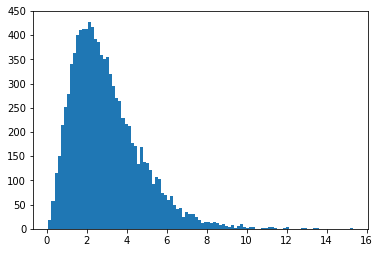

In [32]:
print('Visualise distribution for Erlang generator')

a = [int(random.gammavariate(4, 1)) for i in range(10000)]
a = np.random.gamma(3, 1, size=10000)

plt.hist(a, bins=100)
plt.show()